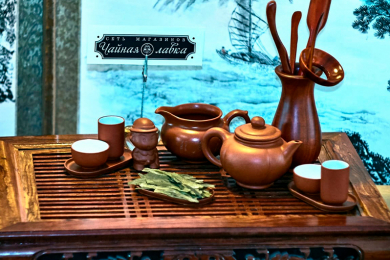

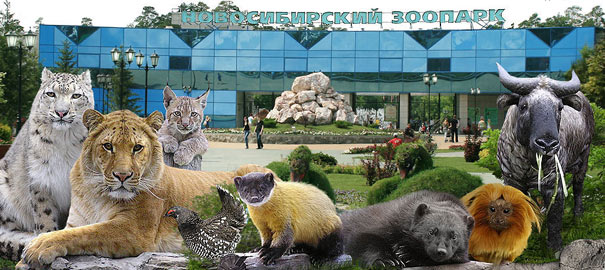

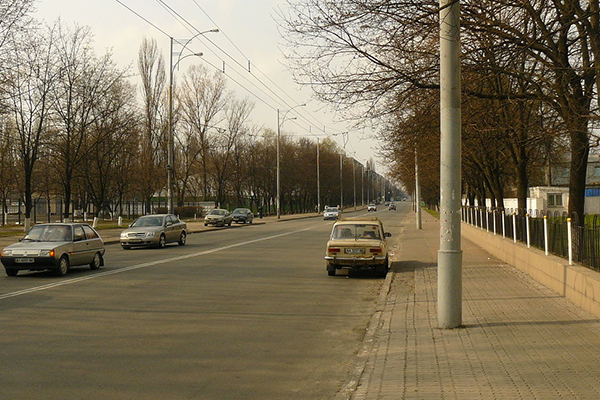

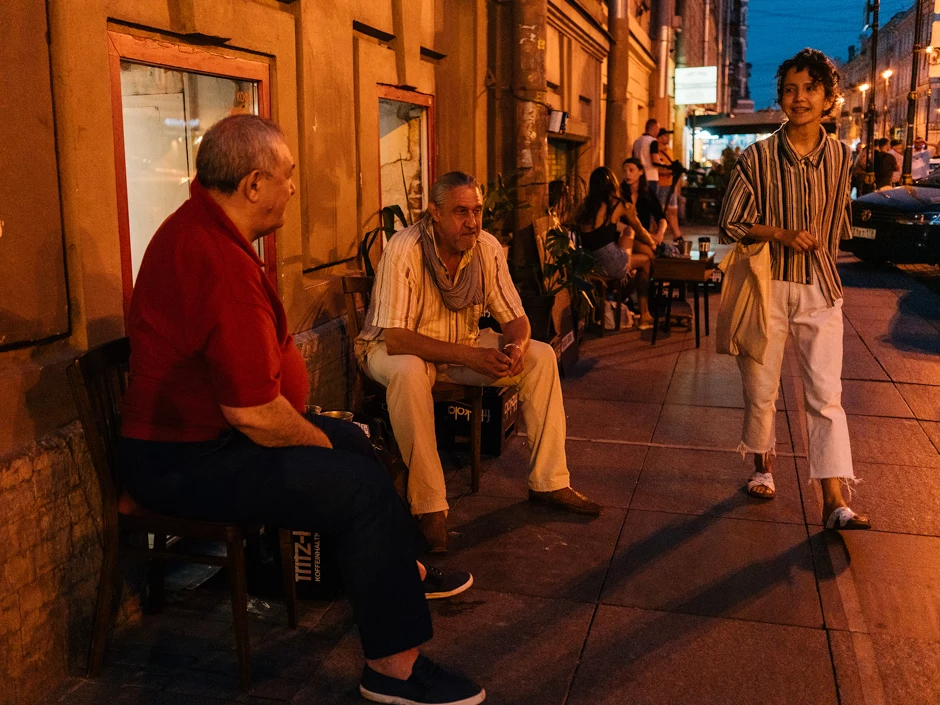

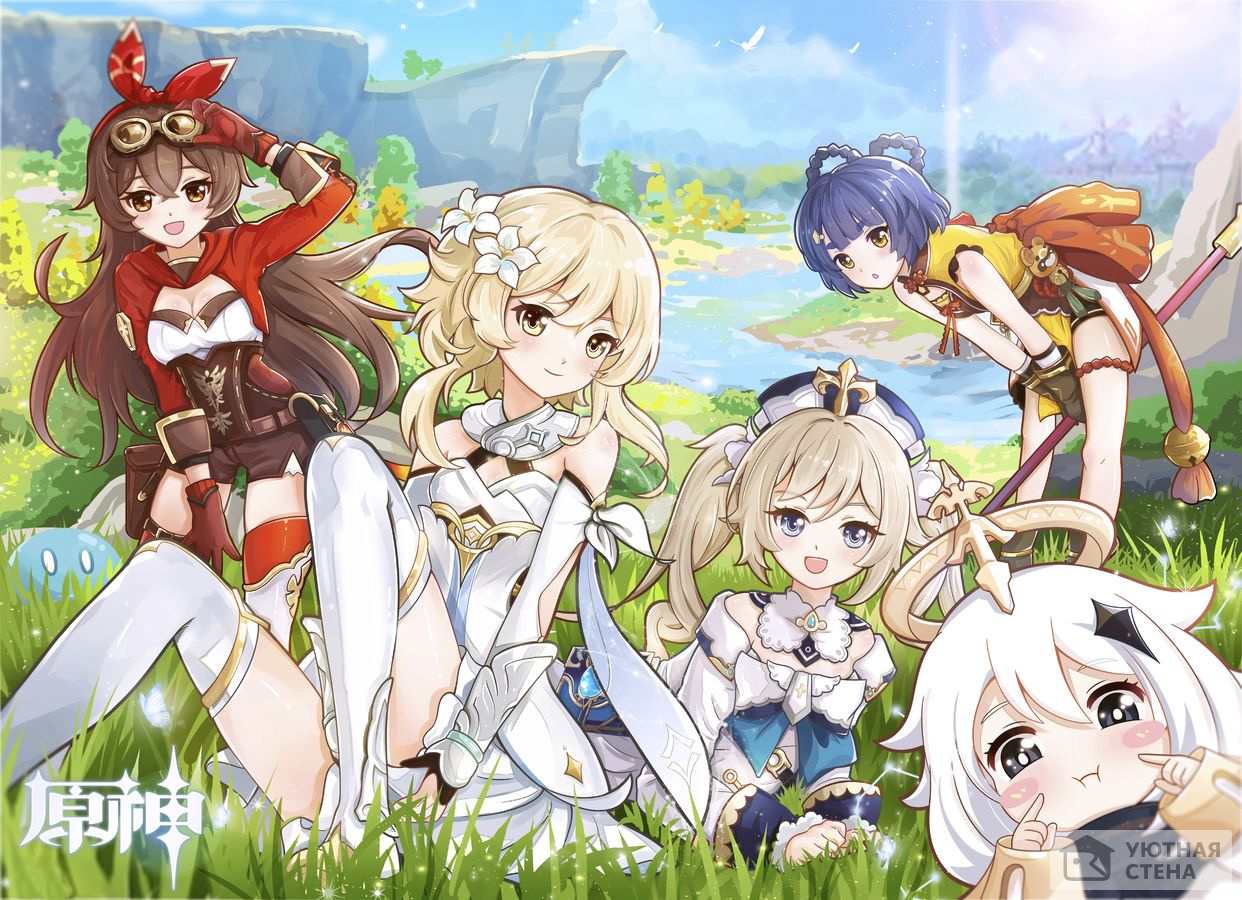

In [1]:
import cv2
from google.colab.patches import cv2_imshow
import os
import re

os.listdir(".")
img_list = []
for img in os.listdir("."):
  if len(re.findall(r"\w+.jpg\b", img)):
    img_list+= [img]
    img = cv2.imread(img)
    cv2_imshow(img)
    print()


In [2]:
import torch
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: p

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [3]:
ssd_model.to('cuda')
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [4]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [6]:
inputs = [utils.prepare_input(img) for img in img_list]
tensor = utils.prepare_tensor(inputs, precision == 'fp16')

In [7]:
with torch.no_grad():
    detections_batch = ssd_model(tensor)

In [8]:
print(len(detections_batch))
print(len(detections_batch[0]), detections_batch[0].shape)
print(len(detections_batch[1]), detections_batch[1].shape)

2
5 torch.Size([5, 4, 8732])
5 torch.Size([5, 81, 8732])


In [17]:
results_per_input = utils.decode_results(detections_batch)
print(len(results_per_input), len(results_per_input[0]), 
      results_per_input[1][0].shape, results_per_input[1][1].shape, results_per_input[1][2].shape)

best_results_per_input = [utils.pick_best(results, 0.70) for results in results_per_input]
print(len(best_results_per_input), len(best_results_per_input[0]), 
      best_results_per_input[1][0].shape, best_results_per_input[1][1].shape, best_results_per_input[1][2].shape)

5 3 (20, 4) (20,) (20,)
5 3 (2, 4) (2,) (2,)


In [18]:
classes_to_labels = utils.get_coco_object_dictionary()

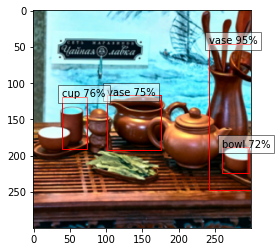

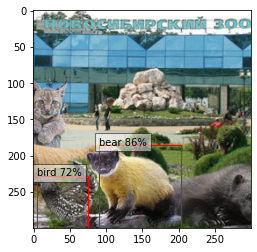

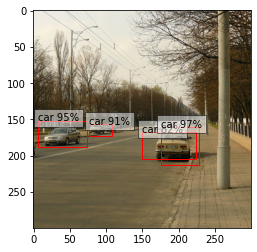

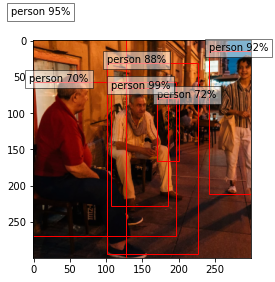

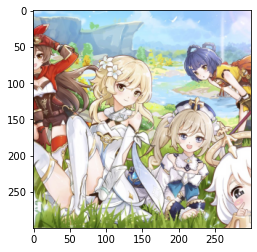

In [19]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()